# Brazil Medical: No Show Appointments Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 
This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.

Original dataset provided by Joni Hoppen and Aquarela Analytics via [Kaggle](https://www.kaggle.com/datasets/joniarroba/noshowappointments).
- ‘ScheduledDay’ tells us on what day the patient set up their appointment.
- ‘Neighborhood’ indicates the location of the hospital.
- ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.

### Question(s) for Analysis

The primary question for analysis is "What groups of individuals are least likely to show up for their appointments?" 
- Do demographics impact likelithood?
    - Does affliction?
    - Facility process?
- Which months have the most No Shows?

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [28]:
def data(file):
    df = pd.read_csv(file,
                    parse_dates=['ScheduledDay', 'AppointmentDay'])
    return df

df = data('data/kaggleV2-may-2016.csv')
# Review columns & dtype
#print(df.info())

# Review column values
#print(df.head())

# Check for duplicates
#print("Duplicate Values: {}".format(sum(df.duplicated())))

**DATA REVIEW**
- No null values
- No duplicates
- Convert names to snake case
- Optimize data types
- Handicap has more than 0/1 values 

### Data Cleaning

In [29]:
# Rename columns
df.rename(columns=lambda s: s.lower().replace('day', '_day')
                                        .replace('id', '_id')
                                        .replace('-', '_')
                                        .replace('handcap', 'handicap'), inplace=True)

# Change data types
df.patient_id = df.patient_id.astype('string')
df.appointment_id = df.appointment_id.astype('string')
df.gender = df.gender.astype('category')
df.age = df.age.astype('int16')
df.neighbourhood = df.neighbourhood.astype('category')
df.scholarship = df.scholarship.astype('bool')
df.hipertension = df.hipertension.astype('bool')
df.diabetes = df.diabetes.astype('bool')
df.alcoholism = df.alcoholism.astype('bool')
df.sms_received = df.sms_received.astype('bool')
df.no_show = df.no_show == 'Yes'  

# Fix Handicap (had multiple non-bool values)
df.handicap = df.handicap > 0

<a id='eda'></a>
## Exploratory Data Analysis

### Is there a difference in no-show rates between genders?

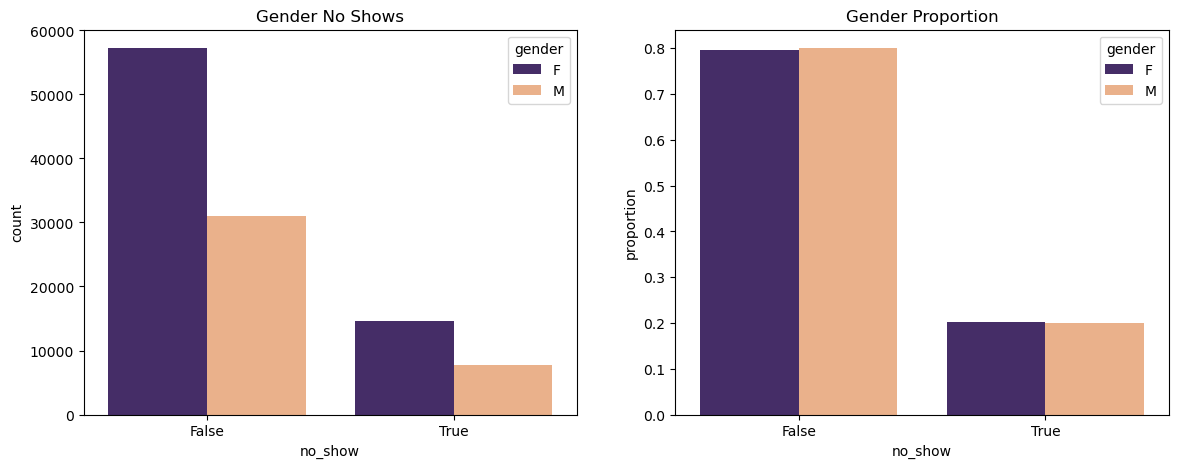

In [30]:
# Generate plot figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5));

# Plot no-show count by gender
sns.countplot(data=df, x='no_show', hue='gender', palette=['#432371',"#FAAE7B"], ax=ax1);
ax1.set_title('Gender No Shows');

# Plot no-show rate by gender
g_prop = df.groupby('gender').no_show.value_counts(normalize=True)
g_prop = g_prop.reset_index()
sns.barplot(data=g_prop, x='no_show', y='proportion', hue='gender', palette=['#432371',"#FAAE7B"], ax=ax2);
ax2.set_title('Gender Proportion');

**Reasoning:**
Woman visit the hospital nearly twice as often as men, but it looks like one gender doesn't "no-show" more than the other. The other data segments we explore below seem to be more likely candidates for further exploration.

### What is the age range?

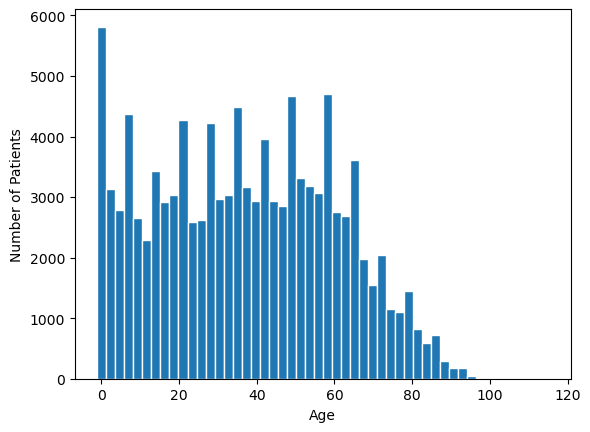

In [49]:
plt.hist(data=df, x='age', bins=50, edgecolor='white');
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.title = ('Age Distrubtion') 

**Reasoning:**
The peaks throughout the age range are worth exploring in further analysis. They could indicate why certain groups come in more frequently, which we could then further assess for correlation to no show rates. 

### How does age affect no show rate?

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64


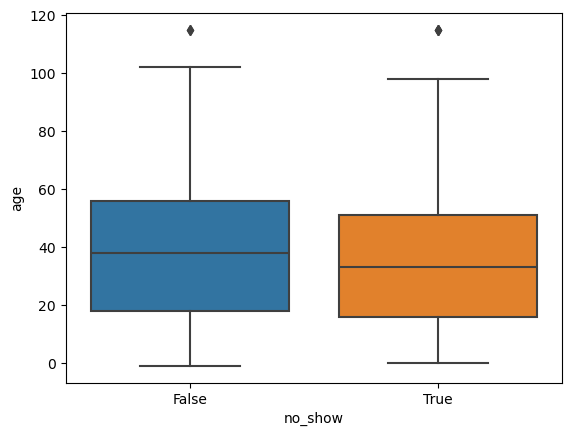

In [32]:
print(df.age.describe())
sns.boxplot(data=df, x='no_show', y='age');

**Reasoning:**
The average age for no shows is a few years younger than that of patients that showed up. It could be worth diving deeper into the age segments for no shows to see if there are specific age groups bringing down the average.

### Is there a difference in no-show rates amongst afflicted groups?

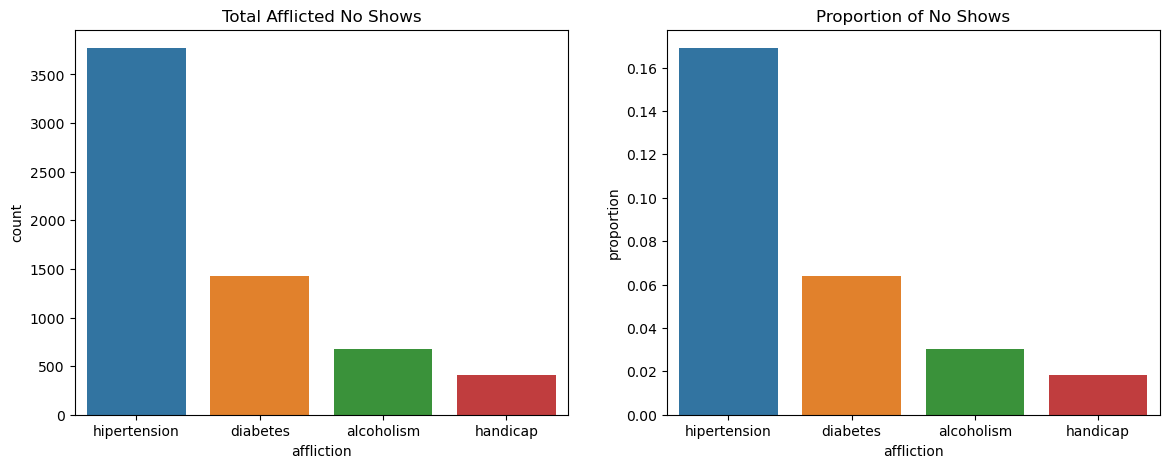

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5));
df_a = df.query("no_show").melt(value_vars=['hipertension', 'diabetes', 'alcoholism', 'handicap'], var_name='affliction')

# Plot no-show count by affliction
sns.countplot(data=df_a.query('value'), x='affliction', ax=ax1)
ax1.set_title('Total Afflicted No Shows');

# Plot no-show rate by affliction
d = df_a.groupby('affliction').value_counts(normalize=True)
d = d.reset_index()
sns.barplot(data=d.query('value').sort_values('proportion', ascending=False), x='affliction', y='proportion', ax=ax2);
ax2.set_title('Proportion of No Shows');

**Reasoning:**
The proportion of no-shows across affliction is very interesting. The patients with afflictions had less no-shows. We could explore this relationship to see if there is a statistically relevant relationship between affliction and no-show rate.  

<a id='conclusions'></a>
## Conclusions
A review of no shows by gender reveals that woman visit the hospital nearly twice as often as men, but one gender doesn't "no-show" more than the other.

All afflicted sample groups had a lower proportion of no-shows compared to the entire population (refer to Gender Proportion above). If we dig deeper, we can see that different afflicted populations have varying no-show rates. Only 2% of handicapped patients didn't show up compared to 17% of patients with hipertension. We would have to look into statistical significance to see if there is actually a correlation between affliction and the chance somwone will not show up.

The age distribution looks very similar for patients that show up vs those that didn't. Albeit, the average age for no shows is a few years younger than that of patients that showed up.

This exploratory analysis is limited in it's depth. Several variables have yet to be explored, such as the impact of sms, scholarships, location, and scheduling time. I also didn't do any statistical testing in order to measure correlation, thus any conclusions we draw from the visuals are based solely on intuition. These are ways we could dive deeper into the analysis given more time.